# Sparkify Project

Analyze data and model churn for simulated music streaming company. 12GB dataset analyzed using Amazon EMR notebook and cluster, as well as locally on 120MB subset of data.

May-13-2019

Tyler Watkins

In [157]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import avg, col, concat, desc, asc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Load and Clean Dataset

In [4]:
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

In [5]:
df.count()

286500

In [6]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [7]:
df = df.filter(df["userId"] != "")
df.count()

278154

## Exploratory Data Analysis

In [8]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [9]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))

songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

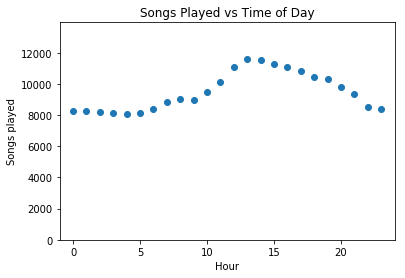

In [10]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24)
plt.ylim(0, 1.2 * np.max(songs_in_hour_pd["count"]))
plt.title("Songs Played vs Time of Day")
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [11]:
# Look at distribution of pageviews
page_df = df.groupby("page").count()
page_df.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [12]:
# Get list of pages
pages = [row['page'] for row in page_df.select("page").collect()]

## Define Churn

`churn` is labelled using the `Cancellation Confirmation` events, which happen for both paid and free users. `Submit Downgrade` events are also labelled as `downgraded`.

In [13]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgraded", flag_downgrade_event("page"))

In [14]:
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", flag_cancellation_event("page"))

In [15]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='21', downgraded=0, churn=0)

In [16]:
# 52 users churned
df.filter(df.churn == 1) \
    .select('userId', 'churn') \
    .dropDuplicates() \
    .count()

52

In [52]:
# 225 total users
df.filter(df.churn == 0) \
    .select('userId', 'churn') \
    .dropDuplicates() \
    .count()

225

In [18]:
# Get lists of users
df_churned = df.filter(df.churn == 1).select('userId', 'churn').dropDuplicates()
churn_users = [row['userId'] for row in df_churned.select("userId").collect()]

df_allusers = df.filter(df.churn == 0).select('userId', 'churn').dropDuplicates()
all_users = [row['userId'] for row in df_allusers.select("userId").collect()]

stay_users = list(set(all_users)-set(churn_users))

## Pandas Data Exploration
Find features that relate to churn.

In [19]:
# Do visualizations using pandas
data = df.toPandas()

In [134]:
data2 = data[["userId","page"]]

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
feature = onehot_encoder.fit_transform(data2[['page']])

pages_list = list(data2.page.unique())
#data2.page.value_counts()
page_list_correct = ['About', 'Add Friend', 'Add to Playlist', 'Cancel', 'Cancellation Confirmation',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade']

pages = pd.DataFrame(feature)
pages['userId'] = data2['userId']
pages_agg = pages.groupby('userId').mean()
#pages.groupby('userId').sum()
pages_agg.columns = page_list_correct

In [135]:
pages_agg.rename(columns={'Cancellation Confirmation':"Churn"}, inplace=True)
pages_agg = pages_agg.drop(['Cancel'], axis=1)
for i in range(len(pages_agg)):
    if pages_agg.iloc[i].Churn > 0.0:
        pages_agg.iloc[i].Churn = 1.0

data3 = data[["userId","page","level","gender"]]
users_levels = data3.groupby("userId").describe()['level'][['unique','top']]
df_new = pd.merge(pages_agg, users_levels, on='userId')
df_new.unique = df_new.unique.astype(float)
df_new['gender'] = data3.groupby("userId").describe()['gender']['top'].values

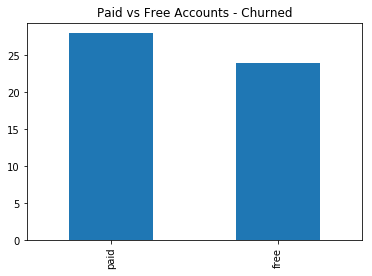

In [136]:
plt.title("Paid vs Free Accounts - Churned")
df_new[df_new.Churn == 1.0].top.value_counts().plot(kind='bar');

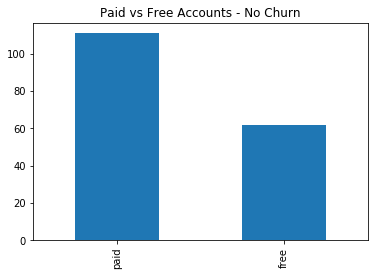

In [137]:
plt.title("Paid vs Free Accounts - No Churn")
df_new[df_new.Churn == 0.0].top.value_counts().plot(kind='bar');

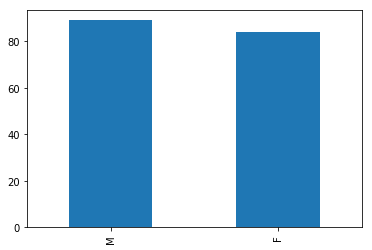

In [138]:
df_new[df_new.Churn == 0.0].gender.value_counts().plot(kind='bar');

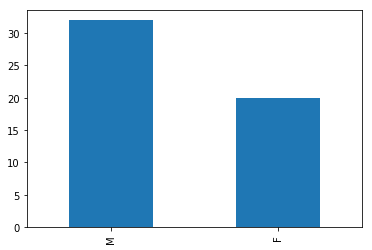

In [139]:
df_new[df_new.Churn == 1.0].gender.value_counts().plot(kind='bar');

In [140]:
df_new.head()

,About,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,Logout,NextSong,...,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,unique,top,gender
userId,,,,,,,,,,,,,,,,,,,,,
10,0.003,0.015,0.011,0.000,0.009,0.000,0.001,0.038,0.014,0.847,...,0.001,0.009,0.000,0.000,0.005,0.047,0.000,1.000,paid,M
100,0.004,0.015,0.019,0.000,0.009,0.001,0.006,0.033,0.011,0.834,...,0.002,0.003,0.000,0.000,0.008,0.046,0.000,2.000,paid,M
100001,0.000,0.011,0.016,1.000,0.000,0.005,0.005,0.059,0.037,0.711,...,0.000,0.005,0.000,0.000,0.011,0.043,0.011,1.000,free,F
100002,0.000,0.005,0.023,0.000,0.009,0.000,0.000,0.028,0.005,0.894,...,0.000,0.000,0.000,0.000,0.000,0.023,0.000,1.000,paid,F
100003,0.000,0.000,0.026,1.000,0.000,0.000,0.013,0.090,0.038,0.654,...,0.000,0.000,0.000,0.000,0.000,0.038,0.000,1.000,free,F


In [141]:
df_new['free'] = pd.DataFrame(onehot_encoder.fit_transform(df_new[['top']]))[0].values
df_new['paid'] = pd.DataFrame(onehot_encoder.fit_transform(df_new[['top']]))[1].values
df_new['female'] = pd.DataFrame(onehot_encoder.fit_transform(df_new[['gender']]))[0].values
df_new['male'] = pd.DataFrame(onehot_encoder.fit_transform(df_new[['gender']]))[1].values

In [142]:
churn_cor = df_new.corr()[['Churn']]
churn_cor = churn_cor[churn_cor.Churn<0.9]

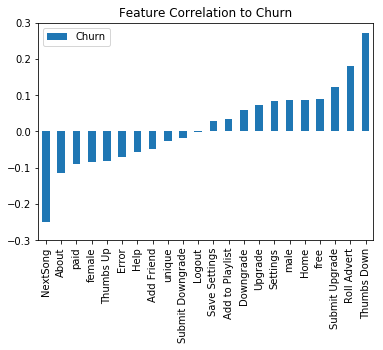

In [143]:
churn_cor.sort_values(by='Churn').plot(kind='bar')
plt.title('Feature Correlation to Churn')
plt.ylim([-0.3, 0.3]);

From above we can see that our best features correlated to Churn are: 

- Avg pageviews for Thumbs Down (0.27) 
- Avg pageviews for NextSong (-0.25)
- Avg pageviews for Roll Advert (0.18) 

This is not surprising. The higher percentage of time the user spends seeing advertisements or disliking music the more likely they are to cancel their service. The higher percentage of time the user spends listening to music the more likely they are to stay.

In [144]:
# Prepare data for modelling
df_new = df_new.drop(['top'], axis=1)
df_new = df_new.drop(['gender'], axis=1)
df_new = df_new.drop(['female'], axis=1)
df_new = df_new.drop(['free'], axis=1)

## PySpark Feature Engineering
Build out the features that are promising to train your model on.

In [31]:
df_less = df.select(['churn', 'userId', 'page', 'level', 'gender'])

In [32]:
df_less.show()

+-----+------+---------------+-----+------+
|churn|userId|           page|level|gender|
+-----+------+---------------+-----+------+
|    0|    30|       NextSong| paid|     M|
|    0|     9|       NextSong| free|     M|
|    0|    30|       NextSong| paid|     M|
|    0|     9|       NextSong| free|     M|
|    0|    30|       NextSong| paid|     M|
|    0|     9|       NextSong| free|     M|
|    0|     9|       NextSong| free|     M|
|    0|    30|       NextSong| paid|     M|
|    0|    30|Add to Playlist| paid|     M|
|    0|    30|       NextSong| paid|     M|
|    0|     9|       NextSong| free|     M|
|    0|     9|    Roll Advert| free|     M|
|    0|    30|       NextSong| paid|     M|
|    0|     9|       NextSong| free|     M|
|    0|     9|      Thumbs Up| free|     M|
|    0|    30|       NextSong| paid|     M|
|    0|     9|       NextSong| free|     M|
|    0|    74|       NextSong| free|     F|
|    0|    30|       NextSong| paid|     M|
|    0|     9|       NextSong| f

In [72]:
df_predict = df_less.groupby('userId').count()
df_predict = df_predict.withColumnRenamed('count', 'pagecount')

In [73]:
churned = udf(lambda x: 0, IntegerType())
df_predict = df_predict.withColumn("churn", churned(df_predict.userId))

In [74]:
from pyspark.sql.functions import *

df_predict = df_predict\
.withColumn('churn_new',when(df_predict.userId.isin(churn_users), df_predict.churn).otherwise(1))\
.drop(df.churn)\
.select(col('userId'), col('pagecount'), col('churn_new').alias('churn'))

In [75]:
df_predict.filter(df_predict.churn == 1).count()

173

In [200]:
sqlContext = SQLContext(spark)
spark_df = sqlContext.createDataFrame(df_new)

In [203]:
spark_df = spark_df.withColumnRenamed('Churn','label')

In [204]:
spark_df.select('label','About','NextSong','Submit Upgrade','Thumbs Down','Roll Advert').show()

+-----+--------------------+------------------+--------------------+--------------------+--------------------+
|label|               About|          NextSong|      Submit Upgrade|         Thumbs Down|         Roll Advert|
+-----+--------------------+------------------+--------------------+--------------------+--------------------+
|  0.0|0.002515723270440...|0.8465408805031447|                 0.0|0.005031446540880503|0.001257861635220...|
|  0.0| 0.00373366521468575|0.8344741754822651|3.111387678904791...|0.008400746733042938|0.007778469197261979|
|  1.0|                 0.0|0.7112299465240641|                 0.0|  0.0106951871657754|  0.0748663101604278|
|  0.0|                 0.0|0.8944954128440367|                 0.0|                 0.0|0.013761467889908258|
|  1.0|                 0.0|0.6538461538461539|                 0.0|                 0.0| 0.11538461538461539|
|  0.0|                 0.0|0.7566265060240964|0.002409638554216...|0.008835341365461847| 0.06907630522088354|
|

## Modeling with PySpark

Fit models using pyspark.ml.

- Fit GBM and RF Models.
- GBM with best performance.
- Use F1 score as the metric to optimize.

In [205]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=['About','Add Friend','Add to Playlist','Downgrade','Error','Help','Home','Logout',
 'NextSong','Roll Advert','Save Settings','Settings','Submit Downgrade','Submit Upgrade','Thumbs Down','Thumbs Up','Upgrade',
 'unique','paid','male'], outputCol="features")

final_df = vecAssembler.transform(spark_df)

train, test = final_df.randomSplit([0.7, 0.3], seed = 7)

In [187]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfpredictions = rfModel.transform(test)

rfpreds = [row['prediction'] for row in rfpredictions.select("prediction").collect()]
rftest = [row['label'] for row in rfpredictions.select("label").collect()]

# accuracy
np.mean(np.array(rfpreds) == np.array(rftest))

0.7368421052631579

In [206]:
gbm = GBTClassifier(featuresCol='features', labelCol='label', maxDepth=4, maxIter=25, stepSize=0.1, subsamplingRate=1.0)
gbModel = gbm.fit(train)
gbpredictions = gbModel.transform(test)

In [208]:
preds = [row['prediction'] for row in gbpredictions.select("prediction").collect()]
test = [row['label'] for row in gbpredictions.select("label").collect()]

# accuracy
np.mean(np.array(preds) == np.array(test))

0.8157894736842105

In [ ]:
# Parameters to tune
#GBTClassifier(featuresCol='features', labelCol='Churn', maxDepth=5, maxIter=20, stepSize=0.1, subsamplingRate=1.0)

In [212]:
gbm = GBTClassifier(featuresCol = 'features', labelCol = 'label')

pipeline = Pipeline(stages=[gbm])

paramGrid = ParamGridBuilder().addGrid(gbm.maxIter,[20,25]).addGrid(gbm.maxDepth,[4, 5]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [213]:
cvModel = crossval.fit(train)

In [215]:
# Best metric maxIter = 25, maxDepth = 4
cvModel.avgMetrics

[0.5650737087148238,
 0.5576813430471966,
 0.5662624251474425,
 0.5614643196524729]

## Modelling with Scikit-Learn

Fit model with scikit-learn. 

- Best models are GBM() and LDA()
- Use GridSearchCV for find best parameters

In [64]:
df_new['Churn']=df_new['Churn'].astype('str')
df_new.head()

,About,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,Logout,NextSong,...,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,unique,paid,male
userId,,,,,,,,,,,,,,,,,,,,,
10,0.003,0.015,0.011,0.0,0.009,0.000,0.001,0.038,0.014,0.847,...,0.001,0.009,0.000,0.000,0.005,0.047,0.000,1.000,1.000,1.000
100,0.004,0.015,0.019,0.0,0.009,0.001,0.006,0.033,0.011,0.834,...,0.002,0.003,0.000,0.000,0.008,0.046,0.000,2.000,1.000,1.000
100001,0.000,0.011,0.016,1.0,0.000,0.005,0.005,0.059,0.037,0.711,...,0.000,0.005,0.000,0.000,0.011,0.043,0.011,1.000,0.000,0.000
100002,0.000,0.005,0.023,0.0,0.009,0.000,0.000,0.028,0.005,0.894,...,0.000,0.000,0.000,0.000,0.000,0.023,0.000,1.000,1.000,0.000
100003,0.000,0.000,0.026,1.0,0.000,0.000,0.013,0.090,0.038,0.654,...,0.000,0.000,0.000,0.000,0.000,0.038,0.000,1.000,0.000,0.000


In [66]:
# Always guess 0
(225-52)/225

0.7688888888888888

In [67]:
X = df_new.drop('Churn', axis=1)
Y = df_new['Churn']

LR: 0.768889 (0.153059)
LDA: 0.782222 (0.132143)
KNN: 0.715556 (0.110129)
CART: 0.622222 (0.102319)
NB: 0.693333 (0.136554)
SVM: 0.768889 (0.153059)
AB: 0.746667 (0.095942)
GBM: 0.768889 (0.112962)
RF: 0.768889 (0.145789)
ET: 0.742222 (0.133777)


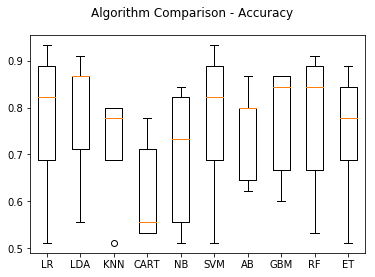

In [68]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.677499 (0.201441)
LDA: 0.742274 (0.165080)
KNN: 0.659070 (0.181344)
CART: 0.620128 (0.128408)
NB: 0.688714 (0.152459)
SVM: 0.677499 (0.201441)
AB: 0.743633 (0.101037)
GBM: 0.751593 (0.121531)
RF: 0.671590 (0.191893)
ET: 0.693310 (0.209856)


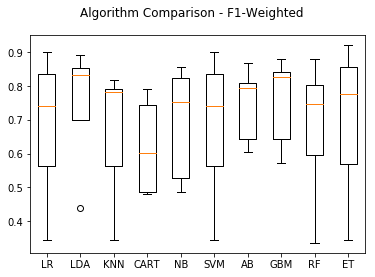

In [69]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='f1_weighted')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - F1-Weighted')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [70]:
# Cross Validation Classification Report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
X = df_new.drop('Churn', axis=1)
Y = df_new['Churn']
test_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 150, subsample = 1.0)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.85      0.73      0.79        56
         1.0       0.25      0.42      0.31        12

   micro avg       0.68      0.68      0.68        68
   macro avg       0.55      0.57      0.55        68
weighted avg       0.75      0.68      0.70        68



In [71]:
# GridsearchCV
from sklearn.model_selection import GridSearchCV

n_estimators = [50, 100, 150]
subsample = [1.0, 0.8, 0.6]
max_depth = [2, 3, 4]
param_grid = dict(n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)


model = GradientBoostingClassifier()

kfold = KFold(n_splits=5, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_weighted', cv=kfold)
grid_result = grid.fit(X, Y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.750369 using {'max_depth': 4, 'n_estimators': 150, 'subsample': 1.0}
0.732012 (0.144351) with: {'max_depth': 2, 'n_estimators': 50, 'subsample': 1.0}
0.729569 (0.159928) with: {'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}
0.708715 (0.164883) with: {'max_depth': 2, 'n_estimators': 50, 'subsample': 0.6}
0.739113 (0.133304) with: {'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}
0.711296 (0.141675) with: {'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
0.693681 (0.159675) with: {'max_depth': 2, 'n_estimators': 100, 'subsample': 0.6}
0.739037 (0.131554) with: {'max_depth': 2, 'n_estimators': 150, 'subsample': 1.0}
0.708678 (0.167248) with: {'max_depth': 2, 'n_estimators': 150, 'subsample': 0.8}
0.720088 (0.124152) with: {'max_depth': 2, 'n_estimators': 150, 'subsample': 0.6}
0.745908 (0.141195) with: {'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
0.721278 (0.142841) with: {'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
0.705019 (0.152522) with: 

In [47]:
# Cross Validation Classification Report
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
X = df_new.drop('Churn', axis=1)
Y = df_new['Churn']
test_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82        56
         1.0       0.29      0.42      0.34        12

   micro avg       0.72      0.72      0.72        68
   macro avg       0.58      0.60      0.58        68
weighted avg       0.76      0.72      0.74        68

